## Part 1: Loading Data

In [11]:
import pandas as pd

def readExportData(year, month):
    """
    Takes int AD year and int month.
    Outputs monthly sum (column) by country (row).
    """
    filename = str(year) + '-' + str(month).zfill(2)
    df = pd.read_csv('//172.20.23.190/ds/Raw Data/MOF-us-2003-2016-rev/' + filename + '.tsv', sep='\t',
                     usecols=['國家', '貨品分類', '價值'])
    df.columns = ['country', 'code', 'val']
    df = df.groupby(['country']).agg({'val': 'sum'}).rename(columns={'val': filename})
    return df

def readImportData(year, month):
    """
    Takes int AD year and int month.
    Outputs monthly sum (column) by HS6 commodity (row).
    """
    filename = str(year) + '-' + str(month).zfill(2)
    df = pd.read_csv('//172.20.23.190/ds/Raw Data/MOF-us-2003-2016-rev/' + filename + '.tsv', sep='\t',
                     usecols=['貨品分類', '價值'], dtype = {'貨品分類': str, '價值': float})
    df.columns = ['code', 'val']
    df['level6'] = df['code'].apply(lambda x: x[:6])
    df = df.groupby(['level6']).agg({'val': 'sum'}).rename(columns={'val': filename})
    return df

In [12]:
import itertools
from functools import reduce

def joinMonthlyData(func, start_year, end_year):
    """
    Uses func to read all monthly data within specified year range, then join by index.
    
    Parameters
    ----------
    func: {readExportData, readImportdata}.
    """
    # Years and months to read
    years = range(start_year, end_year + 1)
    months = range(1, 13)
    year_month = list(itertools.product(years, months))

    # Call func on years and months, cumulatively join each DataFrame
    df_map = map(lambda x, y: func(year=x, month=y), [x[0] for x in year_month], [x[1] for x in year_month])
    df = reduce(lambda x, y: pd.merge(left=x, right=y, how='outer', left_index=True, right_index=True), df_map)

    # Impute NA's and transpose DataFrame
    df.fillna(0, inplace=True)
    df = df.transpose()
    
    return df

In [111]:
# Create column for world, newsouth eighteen and ten
Y = joinMonthlyData(func=readExportData, start_year=2003, end_year=2016)
Y['全球'] = Y.sum(axis=1)
eighteen = ['不丹', '印尼', '印度', '孟加拉', '寮國', '尼泊爾', '巴基斯坦', '斯里蘭卡', '新加坡', '柬埔寨', '汶萊', '泰國', 
            '澳大利亞', '紐西蘭', '緬甸', '菲律賓', '越南', '馬來西亞']
ten = ['印尼', '寮國', '新加坡', '柬埔寨', '汶萊', '泰國', '緬甸', '菲律賓', '越南', '馬來西亞']
Y['十八國'] = Y.loc[:, eighteen].sum(axis=1)
Y['十國'] = Y.loc[:, ten].sum(axis=1)

X = joinMonthlyData(func=readImportData, start_year=2003, end_year=2016)

print('Dimensions of X: {} x {}'.format(X.shape[0], X.shape[1]))
print('Dimensions of Y: {} x {}'.format(X.shape[0], Y.shape[1]))

Dimensions of X: 168 x 5758
Dimensions of Y: 168 x 221


## Part 2: Preprocessing Data

In [112]:
# Keep only non-zero features
X = X.loc[:, (X != 0).all(axis=0)]
print('Dimensions of X: {} x {}'.format(X.shape[0], X.shape[1]))

Dimensions of X: 168 x 2071


In [113]:
# Create lag data for period = 1, ..., 11 and bind by columns
def createLagData(df, periods=1):
    """
    Creates lag data and modify column names.
    """
    lag_df = df.shift(periods=periods)
    lag_df.columns = [c + 'l' + str(periods) for c in df.columns]
    return lag_df
X = pd.concat([X] + list(map(lambda p: createLagData(X, periods=p), range(1, 12))), axis=1)
print('Dimensions of X: {} x {}'.format(X.shape[0], X.shape[1]))

Dimensions of X: 168 x 24852


In [120]:
# Remove the first 11 rows which contain NaN's
X = X.iloc[11:, :]
print('Dimensions of X: {} x {}'.format(X.shape[0], X.shape[1]))
print('X data period: {} ~ {}'.format(X.index[0], X.index[-1]))
print('Y data period: {} ~ {}'.format(Y.index[0], Y.index[-1]))

Dimensions of X: 157 x 24852


In [138]:
# Split test and prediction sets
X_test = X.iloc[-24:-12, :]
Y_test = Y.iloc[-12:, :]
X_pred = X.iloc[-12:, :]
print('Test set:\n' +
      '  X: (12 months up to) {} ~ (12 months up to) {}\n'.format(X_test.index[0], X_test.index[-1]) +
      '  Y:                   {} ~                   {}'.format(Y_test.index[0], Y_test.index[-1]))
print('Prediction set:\n' +
      '  X: (12 months up to) {} ~ (12 months up to) {}\n'.format(X_pred.index[0], X_pred.index[-1]))

Test set:
  X: (12 months up to) 2015-01 ~ (12 months up to) 2015-12
  Y:                   2016-01 ~                   2016-12
Prediction set:
  X: (12 months up to) 2016-01 ~ (12 months up to) 2016-12



In [150]:
# Training data
X = X.iloc[:-24, :]
Y = Y.iloc[(11+12):-12, :]
print('Training data:\n' +
      '  X: (12 months up to) {} ~ (12 months up to) {}\n'.format(X.index[0], X.index[-1]) +
      '  Y:                   {} ~                   {}'.format(Y.index[0], Y.index[-1]))

Training data:
  X: (12 months up to) 2003-12 ~ (12 months up to) 2014-12
  Y:                   2004-12 ~                   2015-12


## Part 3: Mean Normalization and Feature Scaling

In [164]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_mean = scaler.mean_
X_std = scaler.scale_
X = scaler.transform(X)

## Part 4: Plotting Learning Curves

In [224]:
# Split X into training and cross validation sets
from sklearn.model_selection import train_test_split
y = Y['全球']
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.4, random_state=7)
print('Training set size: {}\n'.format(len(X_train)) +
      'Cross validation set size: {}'.format(len(X_cv)))

Training set size: 79
Cross validation set size: 54


In [249]:
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def computeLearningCurveData(X_train, X_cv, y_train, y_cv, n_samples, n_iter=100):
    """
    Iteratively resamples specified number of examples from training and cv sets,
    Uses the selected examples to fit model, and computes training and cv errors.
    Returns averaged training and cv errors.
    """
    train_errors = np.zeros(n_iter)
    cv_errors    = np.zeros(n_iter)
    
    for i in range(n_iter):
        # Randomly select n_samples examples from training and cv sets, respectively
        X_train, y_train = resample(X_train, y_train, n_samples=n_samples, replace=False)
        X_cv, y_cv = resample(X_cv, y_cv, n_samples=n_samples, replace=False)
        # Train model
        regr = Ridge(alpha=1)
        regr.fit(X_train, y_train)
        # Make predictions
        y_train_pred = regr.predict(X_train)
        y_cv_pred    = regr.predict(X_cv)
        # Compute MSE and save to train_errors, cv_errors
        train_errors[i] = mean_squared_error(y_train, y_train_pred)
        cv_errors[i]    = mean_squared_error(y_cv, y_cv_pred)
    
    return np.mean(train_errors), np.mean(cv_errors)

# Compute averaged training and cv errors for m = 1, ..., 50
m_max = 50
train_errors = np.zeros(m_max)
cv_errors    = np.zeros(m_max)

for m in range(1, m_max+1):
    train_error, cv_error = computeLearningCurveData(X_train, X_cv, y_train, y_cv, n_samples=m)
    train_errors[m-1], cv_errors[m-1] = train_error, cv_error

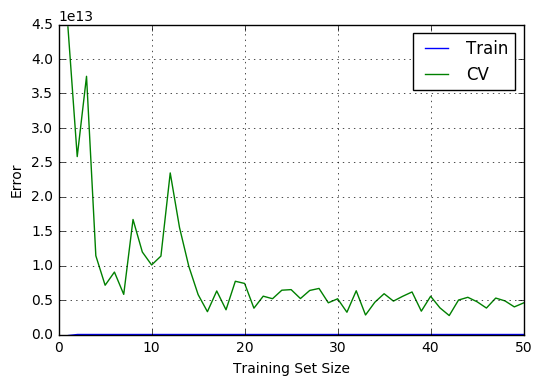

Learning algorithm has high variance.


In [259]:
import matplotlib.pyplot as plt

plt.plot(range(1, m_max+1), train_errors, range(1, m_max+1), cv_errors)
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.legend(['Train', 'CV'])
plt.grid(True)
plt.show()
print('Learning algorithm has high variance.')

## Part 5: Choosing Lambda (to be revised)

In [178]:
# Some useful variables
lambdas = np.logspace(-4, 1, 100)
n_lambdas = len(lambdas)
n_targets = Y.shape[1]
n_iter = 100

train_error = np.zeros((n_lambdas, n_targets))
cv_error = np.zeros((n_lambdas, n_targets))

from sklearn.metrics import mean_squared_error

for i in range(n_lambdas):
    l = lambdas[i]
    train_errors = np.zeros((n_iter, n_targets))
    cv_errors = np.zeros((n_iter, n_targets))
    for j in range(n_iter):
        X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, test_size=0.25)
        regr = Ridge(alpha=l)
        regr.fit(X_train, Y_train)
        Y_train_pred = regr.predict(X_train)
        Y_cv_pred = regr.predict(X_cv)
        train_errors[j, :] = mean_squared_error(Y_train, Y_train_pred, multioutput='raw_values')
        cv_errors[j, :] = mean_squared_error(Y_cv, Y_cv_pred, multioutput='raw_values')
    train_error[i, :] = np.mean(train_errors, axis=0)
    cv_error[i, :] = np.mean(cv_errors, axis=0)

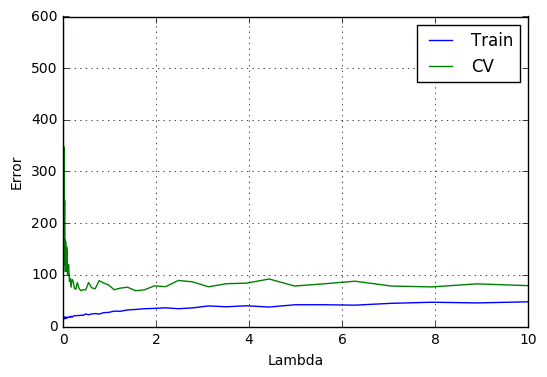

In [179]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(lambdas, train_error[:, 2])
plt.plot(lambdas, cv_error[:, 2])
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.legend(['Train', 'CV'])
plt.grid(True)
plt.show()